# Linear Regression

In this section, I will build a simple **linear regression model** to relate the win precentage of a baseball team to its run differential (i.e., the difference between runs scored and runs allowed). I will use data from five MLB seasons (2011-2015) to train the model and then evaluate the performance of the model on test data from 2016. The game logs used in this segement are sources from [Retrosheet](https://www.retrosheet.org/).

```Train Data```: Game logs from 2011 - 2015

```Test Data```: Game logs of 2016

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

# Data Preprocessing

The first step in any machine learning endeavor is to process the raw input data to extract relevant "features" and to shape the data into the desired format (known as data preprocessing).

I will use game logs from the 2015 MLB season as sample input to build up a sequence of methods, which I will later leverage to process game logs from multiple seasons to construct training and test sets.

In [7]:
# Read games logs from 2015 season into a dataframe
input_df = pd.read_table("../data/train/GL2015.TXT", sep=",", header=None)

In [8]:
input_df.head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,20150405,0,Sun,SLN,NL,1,CHN,NL,1,3,...,David Ross,2,lestj001,Jon Lester,1,lastt001,Tommy La Stella,4,NaN,Y
1,20150406,0,Mon,MIN,AL,1,DET,AL,1,0,...,Nick Castellanos,5,avila001,Alex Avila,2,iglej001,Jose Iglesias,6,NaN,Y
2,20150406,0,Mon,CLE,AL,1,HOU,AL,1,0,...,Jed Lowrie,6,rasmc001,Colby Rasmus,7,marij002,Jake Marisnick,8,NaN,Y
3,20150406,0,Mon,CHA,AL,1,KCA,AL,1,1,...,Alex Rios,9,peres002,Salvador Perez,2,infao001,Omar Infante,4,NaN,Y
4,20150406,0,Mon,TOR,AL,1,NYA,AL,1,6,...,Alex Rodriguez,10,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y


The dataset comes with unlabeled columns, so later I will label the columns of interest to make subsequent code more redable. This [webpage](https://www.retrosheet.org/gamelogs/glfields.txt) provides a key to what each column of data represents, and is a must-have reference when working with Retrosheet game logs.

In [9]:
# Method to rename columns of an input dataframe (for readability)
# Input type: dataframe
# Output type: dataframe

def rename_columns(input_df):
    input_df.rename(columns = {3: 'Visiting Team',
                              6: 'Home Team',
                              9: 'Runs Visitor',
                             10: 'Runs Home'}, inplace= True)
    
    return input_df

# Invoke function to rename columns
input_df = rename_columns(input_df)

# Display
input_df.head()

,0,1,2,Visiting Team,4,5,Home Team,7,8,Runs Visitor,...,151,152,153,154,155,156,157,158,159,160
0,20150405,0,Sun,SLN,NL,1,CHN,NL,1,3,...,David Ross,2,lestj001,Jon Lester,1,lastt001,Tommy La Stella,4,NaN,Y
1,20150406,0,Mon,MIN,AL,1,DET,AL,1,0,...,Nick Castellanos,5,avila001,Alex Avila,2,iglej001,Jose Iglesias,6,NaN,Y
2,20150406,0,Mon,CLE,AL,1,HOU,AL,1,0,...,Jed Lowrie,6,rasmc001,Colby Rasmus,7,marij002,Jake Marisnick,8,NaN,Y
3,20150406,0,Mon,CHA,AL,1,KCA,AL,1,1,...,Alex Rios,9,peres002,Salvador Perez,2,infao001,Omar Infante,4,NaN,Y
4,20150406,0,Mon,TOR,AL,1,NYA,AL,1,6,...,Alex Rodriguez,10,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y


In [10]:
# Method to add new columns to indicate whether home team or visiting team won the game
# Input type: dataframe
# Output type: dataframe

def add_new_columns(input_df):
    input_df['Home Win'] = (input_df['Runs Home'] > input_df['Runs Visitor'])
    input_df['Visitor Win'] = (input_df['Runs Visitor'] > input_df['Runs Home'])
    
    return input_df

# Invoke method to add new columns
input_df = add_new_columns(input_df)

# Display
input_df.head()

,0,1,2,Visiting Team,4,5,Home Team,7,8,Runs Visitor,...,153,154,155,156,157,158,159,160,Home Win,Visitor Win
0,20150405,0,Sun,SLN,NL,1,CHN,NL,1,3,...,lestj001,Jon Lester,1,lastt001,Tommy La Stella,4,NaN,Y,False,True
1,20150406,0,Mon,MIN,AL,1,DET,AL,1,0,...,avila001,Alex Avila,2,iglej001,Jose Iglesias,6,NaN,Y,True,False
2,20150406,0,Mon,CLE,AL,1,HOU,AL,1,0,...,rasmc001,Colby Rasmus,7,marij002,Jake Marisnick,8,NaN,Y,True,False
3,20150406,0,Mon,CHA,AL,1,KCA,AL,1,1,...,peres002,Salvador Perez,2,infao001,Omar Infante,4,NaN,Y,True,False
4,20150406,0,Mon,TOR,AL,1,NYA,AL,1,6,...,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y,False,True


In [11]:
# Method to group data by home team and compute relevant statistics
# Input type: dataframe
# Output type: dataframe ( with stats grouped by home team )

def processing_home_team_data(input_df):
    
    # Group by home team
    home_group = input_df.groupby(input_df['Home Team'])
    
    # Compute stats: Number of games, runs scored, runs conceded, wins, run differential
    home_df = home_group[['Runs Visitor', 'Runs Home','Home Win' ]].apply(sum)
    home_df['Home Games'] = home_group['Home Win'].count()
    home_df.rename(columns = {'Runs Visitor': 'Runs by Visitor', 'Runs Home': 'Runs at Home', 'Home Win': 'Wins at Home'}, inplace=True)
    home_df['RD at Home'] = home_df['Runs at Home'] - home_df['Runs by Visitor']
    home_df.index.rename('Team', inplace = True)
    home_df.reset_index(inplace=True)
    
    return home_df


#Invoke method to group data by home team and compute statistics
home_df = processing_home_team_data(input_df)

# Display
home_df.head()

,Team,Runs by Visitor,Runs at Home,Wins at Home,Home Games,RD at Home
0,ANA,298.0,320.0,49.0,81,22.0
1,ARI,372.0,366.0,39.0,81,-6.0
2,ATL,359.0,286.0,42.0,81,-73.0
3,BAL,353.0,408.0,49.0,81,55.0
4,BOS,383.0,433.0,43.0,81,50.0


In [12]:
# Method to group data by visiting team and compute relevant statistics
# Input type: dataframe
# Output type: dataframe (with stats grouped by visiting team)

def processing_visiting_team_data(input_df):
    
    # Group by visiting team
    visit_group = input_df.groupby(input_df['Visiting Team'])
    
    # Compute stats: Number of games, runs scored, runs conceded, wins, run differential
    visit_df = visit_group[['Runs Visitor', 'Runs Home', 'Visitor Win']].apply(sum)
    visit_df['Visit Games'] = visit_group['Visitor Win'].count()
    visit_df.rename(columns = {'Runs Visitor': 'Runs as Visitor', 'Runs Home':'Runs by Home', 'Visitor Win': 'Wins as Visitor'}, inplace=True)
    visit_df['RD as Visitor'] = visit_df['Runs as Visitor'] - visit_df['Runs by Home']
    visit_df.index.rename('Team', inplace=True)
    visit_df.reset_index(inplace=True)
    
    return visit_df

# Invoke method to group data by visiting team and compute statistics
visit_df = processing_visiting_team_data(input_df)

# Display
visit_df.head()

,Team,Runs as Visitor,Runs by Home,Wins as Visitor,Visit Games,RD as Visitor
0,ANA,341.0,377.0,36.0,81,-36.0
1,ARI,354.0,341.0,40.0,81,13.0
2,ATL,287.0,401.0,25.0,81,-114.0
3,BAL,305.0,340.0,32.0,81,-35.0
4,BOS,315.0,370.0,35.0,81,-55.0


In [14]:
# Method to merge dataframes with statistics grouped by home and visiting teams
# and to explicitly compute explanatory and response variables
# Input type : dataframe. dataframe
# output type: dataframe

def merge_data_frames(home_df, visit_df):
    # Compute explanatory and respinse variables
    overall_df = home_df.merge(visit_df, how='outer', left_on='Team', right_on='Team')
    overall_df['RD'] = overall_df['RD at Home'] + overall_df['RD as Visitor']
    overall_df['Win Percent'] = (overall_df['Wins at Home'] + overall_df['Wins as Visitor']) / (overall_df['Home Games'] + overall_df['Visit Games'])
    
    # Return dataframe with explanatory and response variables
    return overall_df


# invoke method to merge home and visitor and response variables
overall_df = merge_data_frames(home_df, visit_df)

# Display
overall_df.head()

,Team,Runs by Visitor,Runs at Home,Wins at Home,Home Games,RD at Home,Runs as Visitor,Runs by Home,Wins as Visitor,Visit Games,RD as Visitor,RD,Win Percent
0,ANA,298.0,320.0,49.0,81,22.0,341.0,377.0,36.0,81,-36.0,-14.0,0.524691
1,ARI,372.0,366.0,39.0,81,-6.0,354.0,341.0,40.0,81,13.0,7.0,0.487654
2,ATL,359.0,286.0,42.0,81,-73.0,287.0,401.0,25.0,81,-114.0,-187.0,0.413580
3,BAL,353.0,408.0,49.0,81,55.0,305.0,340.0,32.0,81,-35.0,20.0,0.500000
4,BOS,383.0,433.0,43.0,81,50.0,315.0,370.0,35.0,81,-55.0,-5.0,0.481481


In [15]:
# Method to collate all data preprocessing steps
# Input type: dataframe
# Output type: dataframe

def extract_linear_reg_inputs(input_df):
    # Rename Columns
    input_df = rename_columns(input_df)
    
    # Add new columns
    input_df = add_new_columns(input_df)
    
    # Group and process data by home team
    home_df = processing_home_team_data(input_df)
    
    # Group and process data by visiting team
    visit_df = processing_visiting_team_data(input_df)
    
    # Merge home and visitor dataframes
    overall_df = merge_data_frames(home_df, visit_df)
    
    return overall_df

# Training Data

In [16]:
# Get training data from 2011-2015 to train the linear regression model

# Inititalize arrays to hold training data
train_run_diff = np.empty([0,1])
train_win_percent = np.empty([0,1])

# Loop
for year in range(2011, 2016):
    # Construct log files name
    file = "GL" + str(year) + ".TXT"
    log_file = "../data/train/" + file
    
    # Read log into a dataframe
    df = pd.read_table(log_file, sep=",", header=None)
    
    # Extract relevant stats into another dataframe
    df_processing = extract_linear_reg_inputs(df)
    
    # Add to training set
    train_run_diff = np.vstack([train_run_diff, df_processing['RD'].values.reshape([-1,1])])
    train_win_percent = np.vstack([train_win_percent, df_processing['Win Percent'].values.reshape([-1, 1])])


In [17]:
# Instantiate an object
linear_regression = linear_model.LinearRegression(fit_intercept=True)

In [18]:
# Compute model parameters with training data
linear_regression.fit(train_run_diff, train_win_percent)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
# Access and display model parameters
print("Slope (a) = ", float(linear_regression.coef_), " intercept (b) = ", float(linear_regression.intercept_))

Slope (a) =  0.0006467879497387064  intercept (b) =  0.4999936726219291


In [21]:
# Get regression score (R-squared)
r_squared = linear_regression.score(train_run_diff, train_win_percent)
print("R-squared for linear fit = ", r_squared)

R-squared for linear fit =  0.8625081265362202


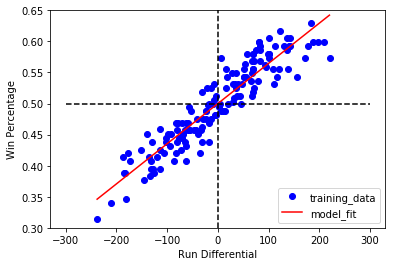

In [27]:
# Visualize
x_axis = np.array(range(int(np.min(train_run_diff)), int(np.max(train_run_diff)))).reshape(-1, 1)
y_axis = linear_regression.coef_ * x_axis + linear_regression.intercept_
plt.plot(train_run_diff, train_win_percent, 'bo', label="training_data")
plt.plot(x_axis, y_axis, 'r', label="model_fit")
plt.plot([-300, 300], [0.5, 0.5], "k--")
plt.plot([0, 0], [0.30, 0.65], "k--")
plt.ylim([0.30, 0.65])
plt.xlabel("Run Differential")
plt.ylabel("Win Percentage")
plt.legend(loc="lower right")
plt.show()

# Test Data

In [41]:
# Construct test dataset
log_file = "./data/test/GL2016.TXT"
df = pd.read_table(log_file, sep=",", header=None)
df_processing = extract_linear_reg_inputs(df)
test_run_diff = df_processing['RD'].values.reshape([-1,1])
test_win_percent = df_processing['Win Percent'].values.reshape([-1,1])

In [42]:
# Predict outcomes using regression model
predict_win_percent = linear_regression.predict(test_run_diff)

In [45]:
# Compute percentage error for linear regression model on test dataset
mean_abs_error_test = np.mean(np.abs(predict_win_percent - test_win_percent))
print("Percentage error on test set = ", 100.*mean_abs_error_test, "%")

# Computer percentage error for linear regression model on training dataset
model_fit_train = linear_regression.predict(train_run_diff)
mean_abs_error_training = np.mean(np.abs(model_fit_train - train_win_percent))
print("Percentage error on training set = ", 100.* mean_abs_error_training, "%")

Percentage error on test set =  2.096802895798953 %
Percentage error on training set =  2.0550910528614867 %


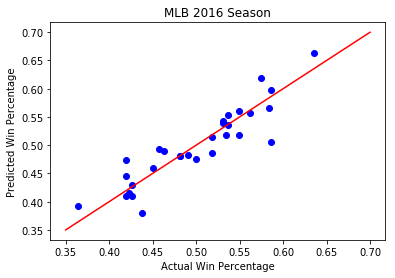

In [47]:
# Visulaize
plt.plot(test_win_percent, predict_win_percent, 'bo')
plt.plot([0.35, 0.7], [0.35, 0.7], 'r')
plt.xlabel("Actual Win Percentage")
plt.ylabel("Predicted Win Percentage")
plt.title("MLB 2016 Season")
plt.show()